# 新段落

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.distributions import Categorical
import numpy as np
import time
import datetime
import os.path as osp
import matplotlib.pyplot as plt
import h5py

In [14]:
class DSN(nn.Module):
    def __init__(self, is_gpu=False):
        super().__init__()
        self.lstm = nn.LSTM(4096,512,1,bidirectional= True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512*2, 11)
        self.softmax = nn.Softmax(dim=-1)
        self.is_gpu = is_gpu
    def forward(self, x):
        #feature = feature.reshape(1,1,feature.shape)
        #input = self.unfold(feature).squeeze(0).unsqueeze(1)
        clips = np.array([np.arange(i-3,i+4) for i in np.arange(x.shape[0])]) % x.shape[0]
        input = torch.zeros(x.shape[0], x.shape[-1])
        if self.is_gpu:
            input = input.cuda()
        for i in range(x.shape[0]):
            input[i,:] = x[clips[i],:].mean(dim=0)
        input = input.unsqueeze(dim=1)
        h,_ = self.lstm(input)
        distribution = self.softmax(self.fc(h.squeeze(dim=1)))
        return  distribution

def act(distribution,x,init_state,tot_epoch=100):
    _distribution = distribution.detach()
    state_space = np.arange(0, x.shape[0])
    action_space = np.array([-16,-8,-4,-2,-1,0,1,2,4,8,16])

    for _ in range(tot_epoch):
        probs = _distribution[init_state]
        probs = probs*eps
        probs[np.arange(probs.shape[0]),torch.argmax(probs,dim=-1).numpy()] *= (1-eps)/eps
        m = Categorical(probs)
        action_idx = m.sample()
        actions = action_space[action_idx.numpy()]
        _state = (init_state + actions) % x.shape[0]
    return _state



# 评估

In [32]:
import json
import math
from tabulate import tabulate


def read_json(fpath):
    with open(fpath, 'r') as f:
        obj = json.load(f)
    return obj


def knapsack_dp(values,weights,n_items,capacity,return_all=False):
#     check_inputs(values,weights,n_items,capacity)

    table = np.zeros((n_items+1,capacity+1),dtype=np.float32)
    keep = np.zeros((n_items+1,capacity+1),dtype=np.float32)

    for i in range(1,n_items+1):
        for w in range(0,capacity+1):
            wi = weights[i-1] # weight of current item
            vi = values[i-1] # value of current item
            if (wi <= w) and (vi + table[i-1,w-wi] > table[i-1,w]):
                table[i,w] = vi + table[i-1,w-wi]
                keep[i,w] = 1
            else:
                table[i,w] = table[i-1,w]

    picks = []
    K = capacity

    for i in range(n_items,0,-1):
        if keep[i,K] == 1:
            picks.append(i)
            K -= weights[i-1]

    picks.sort()
    picks = [x-1 for x in picks] # change to 0-index

    if return_all:
        max_val = table[n_items,capacity]
        return picks,max_val
    return picks


def generate_summary(agent_states, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """Generate keyshot-based video summary i.e. a binary vector.
    Args:
    ---------------------------------------------
    - ypred: predicted importance scores.  (1, seq_len, 1) seq_len = n_subsamples
    - cps: change points, (num_segments, 2), each row stores indices of a segment.
    - n_frames: original number of frames.
    - nfps: number of frames per segment.
    - positions: positions of subsampled frames in the original video.
    - proportion: length of video summary (compared to original video length).
    - method: defines how shots are selected, ['knapsack', 'rank'].
    """
    n_segs = cps.shape[0]
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)
    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])       
    for i in range(len(positions) - 1): # len(position) = n_subsamples
        pos_left, pos_right = positions[i], positions[i+1]
        if i == len(positions): # len(ypred) = n_subsamples
            frame_scores[pos_left:pos_right] = 0
        else:
            for j in range(len(agent_states)):
                if pos_left <= agent_states[j] < pos_right:
                    frame_scores[pos_left:pos_right] = 1

    seg_score = []
    for seg_idx in range(n_segs):
        start, end = int(cps[seg_idx,0]), int(cps[seg_idx,1]+1)
        scores = frame_scores[start:end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        picks = knapsack_dp(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0
        for i in order:
            if total_len + nfps[i] < limits:
                picks.append(i)
                total_len += nfps[i]
    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)
        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element
    return summary


def evaluate_summary(machine_summary, user_summary, eval_metric='avg'):
    """Compare machine summary with user summary (keyshot-based).
    Args:
    --------------------------------
    machine_summary and user_summary should be binary vectors of ndarray type.
    eval_metric = {'avg', 'max'}
    'avg' averages results of comparing multiple human summaries.
    'max' takes the maximum (best) out of multiple comparisons.
    """
    machine_summary = machine_summary.astype(np.float32)
    user_summary = user_summary.astype(np.float32)
    n_users,n_frames = user_summary.shape

    # binarization
    machine_summary[machine_summary > 0] = 1
    user_summary[user_summary > 0] = 1

    if len(machine_summary) > n_frames:
        machine_summary = machine_summary[:n_frames]
    elif len(machine_summary) < n_frames:
        zero_padding = np.zeros((n_frames - len(machine_summary)))
        machine_summary = np.concatenate([machine_summary, zero_padding])

    f_scores = []
    prec_arr = []
    rec_arr = []

    for user_idx in range(n_users):
        gt_summary = user_summary[user_idx,:]
        overlap_duration = (machine_summary * gt_summary).sum()
        precision = overlap_duration / (machine_summary.sum() + 1e-8)
        recall = overlap_duration / (gt_summary.sum() + 1e-8)
        if precision == 0 and recall == 0:
            f_score = 0.
        else:
            f_score = (2 * precision * recall) / (precision + recall)
        f_scores.append(f_score)
        prec_arr.append(precision)
        rec_arr.append(recall)

    if eval_metric == 'avg':
        final_f_score = np.mean(f_scores)
        final_prec = np.mean(prec_arr)
        final_rec = np.mean(rec_arr)
    elif eval_metric == 'max':
        final_f_score = np.max(f_scores)
        max_idx = np.argmax(f_scores)
        final_prec = prec_arr[max_idx]
        final_rec = rec_arr[max_idx]
    
    return final_f_score, final_prec, final_rec


def evaluate(model, dataset, test_keys): # test_keys是测试video的名称字符串列表，dataset是h5文件
    print("==> Test")
    features=dict.fromkeys(test_keys, None)
    with h5py.File('summe_fc6.hdf5',"r") as f:
        for k in test_keys:
            video = f[k]["features"][()]
            features[k] = video#feature
    f.close()
    with torch.no_grad():
        fms = []
        eval_metric = 'avg'

        table = [["No.", "Video", "F-score"]]

#         h5_res = h5py.File('result.h5', 'w')

        for key_idx, key in enumerate(test_keys):
#             seq = dataset[key]['features'][...]
#             seq = torch.from_numpy(seq).unsqueeze(0) # input shape (1, seq_len, dim)
#             if use_gpu: seq = seq.cuda()
#             probs = model(seq, init_state)
#             probs = probs.data.cpu().squeeze().numpy()
        
            cps = dataset[key]['change_points'][...]
            num_frames = dataset[key]['n_frames'][()]
            nfps = dataset[key]['n_frame_per_seg'][...].tolist()
            positions = dataset[key]['picks'][...]
            user_summary = dataset[key]['user_summary'][...]

            X = torch.from_numpy(features[key])
            agent_states = np.linspace(0,X.shape[0],20).astype('int') % X.shape[0]
            distribution = model(X)
            agent_states = act(distribution,X,agent_states,tot_epoch=100)
            
            machine_summary = generate_summary(agent_states, cps, num_frames, nfps, positions)
            fm, _, _ = evaluate_summary(machine_summary, user_summary, eval_metric)
            fms.append(fm)

            table.append([key_idx+1, key, "{:.1%}".format(fm)])
            print(f'{key} is finished')

#             h5_res.create_dataset(key + '/score', data=probs)
#             h5_res.create_dataset(key + '/machine_summary', data=machine_summary)
#             h5_res.create_dataset(key + '/gtscore', data=dataset[key]['gtscore'][...])
#             h5_res.create_dataset(key + '/fm', data=fm)

    print(tabulate(table))

#     h5_res.close()

    mean_fm = np.mean(fms)
    print("Average F-score {:.1%}".format(mean_fm))

    return mean_fm

#训练过程

## 新数据集

In [4]:
dataset = h5py.File('summe_fc6.hdf5', 'r') # dataset是h5格式的可多重迭代对象
num_videos = len(dataset.keys())
splits = read_json('summe_splits.json')  # splits是字典，值是所有video的名字，如“video1”、“video20”
# assert args.split_id < len(splits), "split_id (got {}) exceeds {}".format(args.split_id, len(splits))
split = splits[0]
train_keys = split['train_keys']
test_keys = split['test_keys']

features=dict.fromkeys(train_keys, None)
key_frame_list=dict.fromkeys(train_keys, None)
picks_list = dict.fromkeys(train_keys, None)
with h5py.File('summe_fc6.hdf5',"r") as f:
    for k in train_keys:
        video = f[k]["features"][()]
        key_f = f[k]['fuser_summary'][()]
        picks = f[k]['picks'][()]
        features[k] = video#feature
        key_frame_list[k] = key_f
        picks_list[k] = picks

## 旧数据集

In [4]:
dataset = h5py.File('/Users/Farnante/Desktop/P/视频摘要/eccv16_dataset_summe_google_pool5.h5', 'r') # dataset是h5格式的可多重迭代对象
num_videos = len(dataset.keys())
splits = read_json('summe_splits.json')  # splits是字典，值是所有video的名字，如“video1”、“video20”
# assert args.split_id < len(splits), "split_id (got {}) exceeds {}".format(args.split_id, len(splits))
split = splits[0]
train_keys = split['train_keys']
test_keys = split['test_keys']

features=dict.fromkeys(train_keys, None)
key_frame_list = dict.fromkeys(train_keys, None)
picks_list = dict.fromkeys(train_keys, None)
with h5py.File('eccv16_dataset_summe_google_pool5.h5',"r") as f:
    for k in train_keys:
        video = f[k]["features"][()]
        key_summary = f[k]["user_summary"][()]
        picks = f[k]["picks"][()]
        features[k] = video#feature
        key_frame_list[k] = np.where(np.mean(key_summary,axis=0)> 1/3, 1, 0)
        picks_list[k] = picks

## main

In [86]:
epoch = 700
num_chain = 10
length_per_chain = 20
discount = 0.9
eps = 0.1
is_gpu = False


reward_writer = {}

epoch_list = np.random.choice([300,500,800],size=(10))
index = np.arange(len(features))
np.random.shuffle(index)

ii=0
for idx in index[:10]:
    start_time = time.time()
    model = DSN(is_gpu)
    
    if osp.exists('model_weights.pth'):
        model.load_state_dict(torch.load("model_weights.pth"))
    
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5,  weight_decay=1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    model.train()
    key = train_keys[idx]
    print(f'{key} started training')
    X = torch.from_numpy(features[key])
    if is_gpu:
        X = X.cuda()
    X = X - X.mean(dim=0,keepdim=True)
    n_clips = X.shape[0]
    picks = picks_list[key]

    key_frame = key_frame_list[key]
    key_frame_frac = np.zeros(X.shape[0])
    for i in range(X.shape[0]-1):
        key_frame_frac[i] = np.mean(key_frame[picks[i]:picks[i+1]])
    key_frame_frac[X.shape[0]-1] = np.mean(key_frame[X.shape[0]-1:])
    reward_writer_k = []
    state_writer_k = []
    num_agents = int(X.shape[0]*0.15)
    action_space = np.array([-16,-8,-4,-2,-1,0,1,2,4,8,16])
    init_state = np.linspace(0, X.shape[0],num_agents).astype('int') % X.shape[0]
    
    #init_state = np.random.choice(X.shape[0],size = (agents.shape[0]))
    lr_dict = {}
    epoch = epoch_list[ii]
    for n in range(epoch):
        distribution = model(X)
        init_state = act(distribution, X, init_state)
        reward = torch.tensor(0.)
        if is_gpu:
            reward = reward.cuda()
            
        reward_history = torch.zeros(num_chain, length_per_chain)
        if is_gpu:
            reward_history = reward_history.cuda()

        for j in range(num_chain):
            state = init_state
            u_reward = torch.tensor(0.)
            s_reward = torch.tensor(0.)
            if is_gpu:
                u_reward = u_reward.cuda()
                s_reward = s_reward.cuda()
            for k in range(length_per_chain):
                _X = X.detach()
                key_frame_last = key_frame_frac[state]
                
                probs = distribution[state]
                m = Categorical(probs)
                action_idx = m.sample()
                log_probs = m.log_prob(action_idx)
                _action_idx = action_idx.cpu()
                action = action_space[_action_idx.numpy()]
                state = (state + action) % X.shape[0]
                
                key_frame_now = key_frame_frac[state]
                
                X_a = _X[state]
                X_a = X_a/X_a.norm(p=2, dim=1, keepdim=True)
                M = torch.matmul(X_a, X_a.t())
                gu_reward = 1/2 - (M.sum() - torch.trace(M))/(2*M.shape[0]*(M.shape[0]-1))
                gu_reward = gu_reward.item()
                gs_reward = 1/2 + (key_frame_now.sum() - key_frame_last.sum())/(2*num_agents)
                
                if state[0] not in lr_dict:
                    x = X_a[0]
                    neighbor = np.arange(state[0]-3,state[0]+4) % X.shape[0]
                    X_c = _X[neighbor]
                    X_c = X_c/X_c.norm(p=2, dim=1, keepdim=True)
                    lu_reward = (1 + torch.matmul(x, X_c.t()).min().item())/2
                    lr_dict[state[0]] = lu_reward
                else:
                    lu_reward = lr_dict[state[0]]
                
                key_frame_last_a = key_frame_last[0]
                key_frame_now_a = key_frame_now[0]
                
                if abs(action[0])<=1:
                    ls_reward = (1 + key_frame_now_a - key_frame_last_a)/4 + 1/2
                elif action[0]<-1:
                        pre_state = state[0]-action[0]
                        skip = np.arange(state[0]+1, pre_state) % X.shape[0]
                        skip_r = np.mean(key_frame_frac[skip])
                        ls_reward = (1 + key_frame_now_a - key_frame_last_a)/4 + (1-skip_r)/2
                elif action[0]>1:
                        pre_state = state[0]-action[0]
                        skip = np.arange(pre_state+1 , state[0]) % X.shape[0]
                        skip_r = np.mean(key_frame_frac[skip])
                        ls_reward = (1 + key_frame_now_a - key_frame_last_a)/4 + (1-skip_r)/2
                        
                u_reward = -log_probs[0]*(lu_reward + gu_reward + ls_reward + gs_reward )

                #u_reward = -log_probs[0]*(lu_reward + gu_reward)
            
                for i in range(1,num_agents):
                    if state[i] not in lr_dict:
                        x = X_a[i]
                        neighbor = np.arange(state[i]-3,state[i]+4) % X.shape[0]
                        X_c = _X[neighbor]
                        X_c = X_c/X_c.norm(p=2, dim=1, keepdim=True)
                        lu_reward = (1 + torch.matmul(x, X_c.t()).min().item())/2
                        lr_dict[state[i]] = lu_reward
                    else:
                        lu_reward = lr_dict[state[i]]
                    
                    key_frame_last_a = key_frame_last[i]
                    key_frame_now_a = key_frame_now[i]
                    if abs(action[i])<=1:
                        ls_reward = (1 + key_frame_now_a - key_frame_last_a)/4 + 1/2
                    elif action[i]<-1:
                            pre_state = state[i]-action[i]
                            skip = np.arange(state[i]+1, pre_state) % X.shape[0]
                            skip_r = np.mean(key_frame_frac[skip])
                            ls_reward = (1 + key_frame_now_a - key_frame_last_a)/4 + (1-skip_r)/2
                    elif action[i]>1:
                            pre_state = state[i]-action[i]
                            skip = np.arange(pre_state+1 , state[i]) % X.shape[0]
                            skip_r = np.mean(key_frame_frac[skip])
                            ls_reward = (1 + key_frame_now_a - key_frame_last_a)/4 + (1-skip_r)/2
                        
                    u_reward = -log_probs[i]*(lu_reward + gu_reward + ls_reward + gs_reward )

                    #u_reward = -log_probs[i]*(lu_reward + gu_reward)
                reward_history[j, k] = u_reward

            if n+j == 0:
                elapsed = round(time.time() - start_time)
                elapsed = str(datetime.timedelta(seconds=elapsed))
                #print(f'one epoch for computing a chain cost time (h:m:s): {elapsed}')
                #对每个agent计算reward
        reward_history = reward_history.mean(dim=0)
        for t in range(reward_history.shape[-1]):
            _discount = torch.pow(discount, torch.arange(t, reward_history.shape[-1]))
            reward += torch.matmul(reward_history[t:], _discount.t())
        
        if n == 0:
            elapsed = round(time.time() - start_time)
            elapsed = str(datetime.timedelta(seconds=elapsed))
            #print(f'one epoch for computing reward cost time (h:m:s): {elapsed}')

        optimizer.zero_grad()
        reward.backward()
        optimizer.step() 

        reward_writer_k.append(reward.item())

        elapsed = round(time.time() - start_time)
        elapsed = str(datetime.timedelta(seconds=elapsed))
        if n == 0:
            print(f'one epoch cost time (h:m:s): {elapsed}')
        if n % 50 == 49:
            print(f'{n+1} epoch finished(total epoch: {epoch}). Total time (h:m:s): {elapsed}. Reward = {reward}')
        
        torch.save(model.state_dict(), 'model_weights.pth')
    
    ii+=1
    reward_writer[key] = np.array(reward_writer_k)
    print(f'{key} finished training')
#=========save model============
torch.save(model.state_dict(), 'model_weights.pth')
print(len(reward_writer))

video_25 started training
one epoch cost time (h:m:s): 0:00:01


KeyboardInterrupt: 

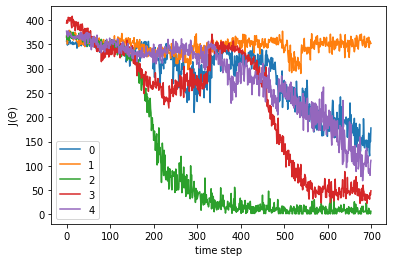

In [40]:
plt.plot(np.arange(reward_writer.shape[-1]),reward_writer[0,:],label = '0')
plt.plot(np.arange(reward_writer.shape[-1]),reward_writer[1,:],label = '1')
plt.plot(np.arange(reward_writer.shape[-1]),reward_writer[2,:],label = '2')
plt.plot(np.arange(reward_writer.shape[-1]),reward_writer[3,:],label = '3')
plt.plot(np.arange(reward_writer.shape[-1]),reward_writer[4,:],label = '4')
plt.ylabel(r'J($\Theta$)')
plt.xlabel('time step')
plt.legend()
plt.savefig('reward')

#加载训练好的模型

In [33]:
model = DSN(is_gpu=False)
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

DSN(
  (lstm): LSTM(4096, 512, bidirectional=True)
  (flatten): Flatten()
  (fc): Linear(in_features=1024, out_features=11, bias=True)
  (softmax): Softmax(dim=-1)
)

In [70]:
dataset = h5py.File('summe_fc6.hdf5', 'r')
eps=0.1
evaluate(model, dataset, test_keys)

==> Test
video_17 is finished
video_2 is finished
video_20 is finished
video_4 is finished
video_9 is finished
---  --------  -------
No.  Video     F-score
1    video_17  19.8%
2    video_2   8.7%
3    video_20  4.4%
4    video_4   4.5%
5    video_9   12.3%
---  --------  -------
Average F-score 9.9%


0.09933924762191598

In [74]:
key = 'video_19'
X = torch.from_numpy(features[key])
X = X - X.mean(dim=0,keepdim=True) 
_key_frame = key_frame_list[key]
picks = picks_list[key]
key_frame_frac = np.zeros(X.shape[0])
num_agents = int(X.shape[0]*0.15)
agents = np.arange(num_agents)


for i in range(X.shape[0]-1):
    key_frame_frac[i] = np.mean(_key_frame[picks[i]:picks[i+1]])
key_frame_frac[X.shape[0]-1] = np.mean(_key_frame[X.shape[0]-1:])

action_space = np.array([-16,-8,-4,-2,-1,0,1,2,4,8,16])
action_idx = torch.argmax(model(X),dim=-1)

dis = model(X)
init_state = np.random.choice(X.shape[0],size = (agents.shape[0]))
state = act(dis,X,init_state,tot_epoch=200)

print(dis)
print(dis.max(dim=-1))
print(f'{key}:')
print('每个片段中关键帧所占比例')
print(key_frame_frac)
print('每个片段在政策下对应的最大可能动作')
print(action_space[action_idx])
print(np.unique(state))
print(np.array(np.where(key_frame_frac>0)).flatten())

tensor([[0.0905, 0.1235, 0.0891,  ..., 0.1210, 0.1033, 0.1059],
        [0.0832, 0.1071, 0.0869,  ..., 0.1356, 0.1069, 0.0993],
        [0.0778, 0.0912, 0.0845,  ..., 0.1426, 0.1060, 0.0869],
        ...,
        [0.0920, 0.2197, 0.0970,  ..., 0.0908, 0.0971, 0.1338],
        [0.0923, 0.1901, 0.0970,  ..., 0.1008, 0.1016, 0.1337],
        [0.0898, 0.1559, 0.0969,  ..., 0.1117, 0.1043, 0.1272]],
       grad_fn=<SoftmaxBackward>)
torch.return_types.max(
values=tensor([0.1235, 0.1356, 0.1426, 0.1420, 0.1387, 0.1340, 0.1282, 0.1309, 0.1331,
        0.1345, 0.1350, 0.1346, 0.1356, 0.1364, 0.1360, 0.1345, 0.1326, 0.1359,
        0.1398, 0.1424, 0.1433, 0.1427, 0.1408, 0.1378, 0.1333, 0.1337, 0.1373,
        0.1397, 0.1412, 0.1417, 0.1418, 0.1412, 0.1404, 0.1391, 0.1373, 0.1343,
        0.1290, 0.1242, 0.1525, 0.1843, 0.2148, 0.2408, 0.2585, 0.2660, 0.2637,
        0.2549, 0.2410, 0.2222, 0.1954, 0.1685, 0.1453, 0.1302, 0.1187, 0.1101,
        0.1104, 0.1114, 0.1173, 0.1213, 0.1203, 0.1152, 0

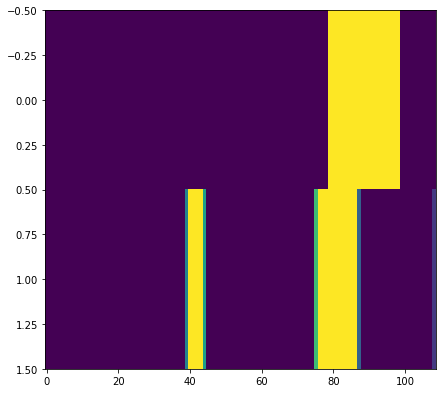

In [75]:
objection = np.expand_dims(np.where(action_space[action_idx]==0,1,0),axis=0)
A = np.vstack((objection,key_frame_frac))
plt.figure(figsize=(7,10))
plt.imshow(A,aspect=50)


In [ ]:
a = torch.randn(10)
a.shape

In [ ]:
b = torch.randn(10,2)
b.shape

In [ ]:
torch.matmul(a,b).min()

In [ ]:
a = a.unsqueeze(0)

In [ ]:
torch.matmul(a,b).min()

In [ ]:
a = torch.randn(3,2,3)
print(a)
print(a.t())

In [14]:
print(X.shape[0])
init_state = np.random.choice(X.shape[0],agents.shape[0])
init_state

108


array([ 37,  84,  84,  81,   5, 101,  87,  56, 102,  72,  30,  21,  75,
        98,  36,  94,  20,  91,  79, 102,  40,  46,  13, 104,  31,  85,
        42,  37,  17,  34,  30])

In [77]:
np.random.choice([300,500,800],size=(10))

array([800, 500, 500, 800, 800, 500, 500, 800, 500, 800])